# Article Relevance Prediction for NeotomaDB

This notebook contains the following tasks:
1. Extract CrossRef metadata of articles that currently exist in Neotoma.csv (positive cases)
2. Extract CrossRef metadata of new articles sent from Simon
3. Extract CrossRef metadata of other negative cases that do not exist in NeotomaDB (negative cases)
4. Data cleaning and saved as csv file
5. Create train test dataset
6. Baseline model: logistic regression with BOW features


### Imports

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Image
pd.set_option("display.max_colwidth", 200)

## 1. Extract CrossRef Metadata for Articles in NeotomaDB

The neotoma.csv file is provided by our partner. 

It contains 6889 site records from 2316 sites.

The csv file contains data contributed from 758 distinct articles. 

Note that only 244 of these articles has abstract.

In [48]:
import requests
import json
import os

In [49]:
# load csv
# neotoma = pd.read_csv("../data/hackathon_data/neotoma_crossref_fixed.csv").iloc[:, 0:-2]
# neotoma.info()

In [50]:
# neotoma['doi'].value_counts()

In [51]:
# neotoma['sitename'].value_counts()

### 8 DOI Not Found, Replaced

In [52]:
# dot_status_df = pd.DataFrame(doi_status)
# dot_status_df.query("status_code == 404")['doi'].to_list()

In [53]:
# doi_replace = {
#     '10.2307/1551601\xa0 ' : '10.2307/1551601',
#     '10.2307/1551050\xa0 ' : '10.2307/1551050',
#     '10.1016/j.revpalbo.2004.09.004\xa0 ': '10.1016/j.revpalbo.2004.09.004',
#     '10.1016/j.quascirev.2016.09.023.' : '10.1016/j.quascirev.2016.09.023',
#     'Widga, C., S.N. Lengyel, J. Saunders, G. Hodgins, J.D. Walker, and A.D. Wanamaker. 2017. Late Pleistocene proboscidean population dynamics in the North American Midcontinent. Boreas 46(4):772-782. [DOI: 10.1111/bor.12235]': '10.1111/bor.12235',
#     "Fiedel, S.J. 2018. The spore conundrum: Does a dung fungus decline signal humans' arrival in the Eastern United States?. Quaternary International 466:247e255. [DOI: doi.org/10.1016/j.quaint.2015.11.130]": '10.1016/j.quaint.2015.11.130',
#     'Joyce, D.J. 2006. Chronology and new research on the Schaefer mammoth (? Mammuthus primigenius) site, Kenosha County, Wisconsin, USA,. Quaternary International 142:44-57. [DOI: doi:10.1016/j.quaint.2005.03.004]': '10.1016/j.quaint.2005.03.004',
#     'Overstreet, D.F., and M.F. Kolb. 2003. Geoarchaeological contexts for Late Pleistocene archaeological sites with human‐modified woolly mammoth remains in southeastern Wisconsin, USA. Geoarchaeology 18(1):91-114. [DOI: DOI:10.1002/gea.10052]': '10.1002/gea.10052'
# }
# neotoma['doi'].replace(to_replace=doi_replace, inplace=True)

### Download metadata from CrossRef

In [54]:
# # Query Metadata from DOI
# doi_list = neotoma['doi'].unique().tolist()
# # testing purpose: take the first 10
# # input_doi = doi_list
# input_doi = doi_list

# doi_status = {}
# doi_status['doi'] = input_doi
# doi_status['status_code'] = []

# for doi in input_doi:
#     cross_ref_url = f"https://api.crossref.org/works/{doi}"

#     # make a request to the API
#     cross_ref_response = requests.get(cross_ref_url)

#     doi_status['status_code'].append(cross_ref_response.status_code)

#     if cross_ref_response.status_code == 200:

#         # save data
#         ref_data = cross_ref_response.json()
        
#         # create the directory if it doesn't exist 
#         directory = '../data/raw/crossref'
#         if not os.path.exists(directory):
#             os.makedirs(directory)

#         # save the JSON data to a file
#         doi_clean = doi.replace("/", "_")
#         filename = f'crossref_{doi_clean}.json'
#         filepath = os.path.join(directory, filename)
#         with open(filepath, 'w') as outfile:
#             json.dump(ref_data, outfile)

#     else:
#         print("DOI not found:", doi, "status_code", cross_ref_response.status_code)

### Positive Cases CrossRef Data Import

In [55]:
# Set the directory path
directory_path = "../data/raw/crossref/positive/"
# Get a list of all files and directories in the directory
files_and_directories = os.listdir(directory_path)
# Filter out the directories to get only the files
files = [file for file in files_and_directories if os.path.isfile(os.path.join(directory_path, file))]
if '.DS_Store' in files:
    files.remove('.DS_Store')
len(files)

757

In [56]:
# initialize empty dataframe
neotoma_crossref_df = pd.DataFrame()

# Populate the cross ref df
for f in files:
    file_path = f"../data/raw/crossref/positive/{f}"
    onefile = pd.read_json(file_path)
    onefile = pd.DataFrame(onefile.loc[:, 'message']).T.reset_index()
    
    # merge
    neotoma_crossref_df = pd.concat([neotoma_crossref_df, onefile])

neotoma_crossref_df["target"] = 1

neotoma_crossref_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 757 entries, 0 to 0
Data columns (total 55 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   index                   757 non-null    object
 1   DOI                     757 non-null    object
 2   ISSN                    745 non-null    object
 3   URL                     757 non-null    object
 4   alternative-id          598 non-null    object
 5   author                  751 non-null    object
 6   container-title         757 non-null    object
 7   content-domain          757 non-null    object
 8   created                 757 non-null    object
 9   deposited               757 non-null    object
 10  indexed                 757 non-null    object
 11  is-referenced-by-count  757 non-null    object
 12  issn-type               745 non-null    object
 13  issue                   673 non-null    object
 14  issued                  757 non-null    object
 15  journal-

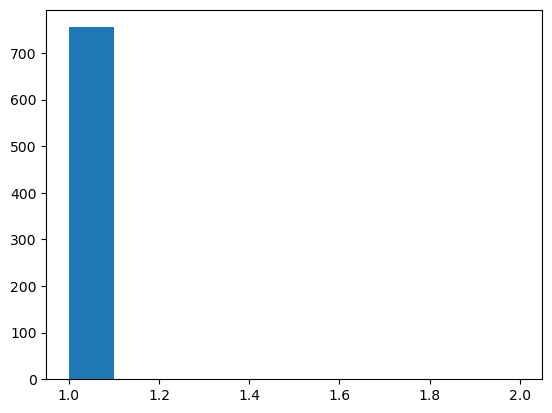

In [57]:
counts = neotoma_crossref_df['DOI'].value_counts()
plt.hist(counts)
plt.show()

### Negative Cases CrossRef Data Import

#### Sample code to search GDD

In [58]:
# #term to search GeoDeepDive
# term = "Animal"
# # Number of articles to return
# n = 100

# response = requests.get("https://geodeepdive.org/api/articles?term=" + term + "&max=" + str(n) + "&type=journal-article")
# if cross_ref_response.status_code == 200:

#         # save data
#         ref_data = response.json()
        
#         # create the directory if it doesn't exist 
#         directory = '../data/raw/negative'
#         if not os.path.exists(directory):
#             os.makedirs(directory)

#         # save the JSON data to a file
#         doi_clean = doi.replace("/", "_")
#         filename = f'crossref_{doi_clean}.json'
#         filepath = os.path.join(directory, filename)
#         with open(filepath, 'w') as outfile:
#             json.dump(ref_data, outfile)

# else:
#     print("DOI not found:", doi, "status_code", cross_ref_response.status_code)

In [59]:
# Set the directory path
directory_path = "../data/raw/crossref/negative/"
# Get a list of all files and directories in the directory
files_and_directories = os.listdir(directory_path)
# Filter out the directories to get only the files
files = [file for file in files_and_directories if os.path.isfile(os.path.join(directory_path, file))]
if '.DS_Store' in files:
    files.remove('.DS_Store')
len(files)

1786

In [60]:
# initialize empty dataframe
negative_crossref_df = pd.DataFrame()

# Populate the cross ref df
for f in files:
    file_path = f"../data/raw/crossref/negative/{f}"
    onefile = pd.read_json(file_path)
    onefile = pd.DataFrame(onefile.loc[:, 'message']).T.reset_index()
    
    # merge
    negative_crossref_df = pd.concat([negative_crossref_df, onefile])
negative_crossref_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1786 entries, 0 to 0
Data columns (total 50 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   index                   1786 non-null   object
 1   DOI                     1786 non-null   object
 2   ISSN                    1784 non-null   object
 3   URL                     1786 non-null   object
 4   archive                 475 non-null    object
 5   author                  1335 non-null   object
 6   container-title         1786 non-null   object
 7   content-domain          1786 non-null   object
 8   created                 1786 non-null   object
 9   deposited               1786 non-null   object
 10  indexed                 1786 non-null   object
 11  is-referenced-by-count  1786 non-null   object
 12  issn-type               1784 non-null   object
 13  issue                   1501 non-null   object
 14  issued                  1786 non-null   object
 15  journal

In [61]:
negative_crossref_df.head(3)

index                            DOI                    ISSN  \
0  message         10.1002/chin.201507318             [0931-7597]   
0  message         10.1002/chem.201590048             [0947-6539]   
0  message  10.1080/13698575.2015.1031645  [1369-8575, 1469-8331]   

                                               URL    archive  \
0         http://dx.doi.org/10.1002/chin.201507318  [Portico]   
0         http://dx.doi.org/10.1002/chem.201590048        NaN   
0  http://dx.doi.org/10.1080/13698575.2015.1031645        NaN   

                                                                                                                                                                                                    author  \
0                              [{'given': 'Kristof', 'family': 'Kranjc', 'sequence': 'first', 'affiliation': []}, {'given': 'Marijan Koc', 'family': 'evar', 'sequence': 'additional', 'affiliation': []}]   
0  [{'given': 'Jin-Long', 'family': 'Wang', 'sequence': 'first', 'affiliation': []}, {'given': 'Jian-Wei', 'family': 'Liu', 'sequence': 'additional', 'affiliation': []}, {'given': 'Bing-Zhang', 'fami...   
0  [{'given': 'Davina', 'family': 'Lohm', 'sequence': 'first', 'affiliation': []}, {'given': 'Mark', 'family': 'Davis', 'sequence': 'additional', 'affiliation': []}, {'given': 'Paul', 'family': 'Flow...   

                    container-title  \
0                      [ChemInform]   
0  [Chemistry - A European Journal]   
0      [Health, Risk &amp; Society]   

                                                       content-domain  \
0                      {'domain': [], 'crossmark-restriction': False}   
0                      {'domain': [], 'crossmark-restriction': False}   
0  {'domain': ['www.tandfonline.com'], 'crossmark-restriction': True}   

                                                                                            created  \
0  {'date-parts': [[2015, 1, 29]], 'date-time': '2015-01-29T10:38:37Z', 'timestamp': 1422527917000}   
0  {'date-parts': [[2015, 3, 12]], 'date-time': '2015-03-12T19:27:18Z', 'timestamp': 1426188438000}   
0  {'date-parts': [[2015, 4, 15]], 'date-time': '2015-04-15T12:23:23Z', 'timestamp': 1429100603000}   

                                                                                          deposited  \
0   {'date-parts': [[2021, 7, 2]], 'date-time': '2021-07-02T09:01:39Z', 'timestamp': 1625216499000}   
0   {'date-parts': [[2021, 7, 3]], 'date-time': '2021-07-03T01:59:45Z', 'timestamp': 1625277585000}   
0  {'date-parts': [[2017, 6, 23]], 'date-time': '2017-06-23T05:27:18Z', 'timestamp': 1498195638000}   

   ... volume                   alternative-id  \
0  ...     46                              NaN   
0  ...     21                              NaN   
0  ...     17  [10.1080/13698575.2015.1031645]   

                                                                                                                                                                                                 assertion  \
0                                                                                                                                                                                                      NaN   
0                                                                                                                                                                                                      NaN   
0  [{'value': 'The publishing and review policy for this title is described in its Aims & Scope.', 'order': 1, 'name': 'peerreview_statement', 'label': 'Peer Review Statement'}, {'value': 'http://www...   

                                                                                funder  \
0                                                                                  NaN   
0                                                                                  NaN   
0  [{'name': 'Australia Research Council Discovery Project', 'award': 

In [62]:
negative_crossref_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1786 entries, 0 to 0
Data columns (total 50 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   index                   1786 non-null   object
 1   DOI                     1786 non-null   object
 2   ISSN                    1784 non-null   object
 3   URL                     1786 non-null   object
 4   archive                 475 non-null    object
 5   author                  1335 non-null   object
 6   container-title         1786 non-null   object
 7   content-domain          1786 non-null   object
 8   created                 1786 non-null   object
 9   deposited               1786 non-null   object
 10  indexed                 1786 non-null   object
 11  is-referenced-by-count  1786 non-null   object
 12  issn-type               1784 non-null   object
 13  issue                   1501 non-null   object
 14  issued                  1786 non-null   object
 15  journal

In [63]:
#Setting target column
negative_crossref_df["target"] = 0
negative_crossref_df.head(3)

index                            DOI                    ISSN  \
0  message         10.1002/chin.201507318             [0931-7597]   
0  message         10.1002/chem.201590048             [0947-6539]   
0  message  10.1080/13698575.2015.1031645  [1369-8575, 1469-8331]   

                                               URL    archive  \
0         http://dx.doi.org/10.1002/chin.201507318  [Portico]   
0         http://dx.doi.org/10.1002/chem.201590048        NaN   
0  http://dx.doi.org/10.1080/13698575.2015.1031645        NaN   

                                                                                                                                                                                                    author  \
0                              [{'given': 'Kristof', 'family': 'Kranjc', 'sequence': 'first', 'affiliation': []}, {'given': 'Marijan Koc', 'family': 'evar', 'sequence': 'additional', 'affiliation': []}]   
0  [{'given': 'Jin-Long', 'family': 'Wang', 'sequence': 'first', 'affiliation': []}, {'given': 'Jian-Wei', 'family': 'Liu', 'sequence': 'additional', 'affiliation': []}, {'given': 'Bing-Zhang', 'fami...   
0  [{'given': 'Davina', 'family': 'Lohm', 'sequence': 'first', 'affiliation': []}, {'given': 'Mark', 'family': 'Davis', 'sequence': 'additional', 'affiliation': []}, {'given': 'Paul', 'family': 'Flow...   

                    container-title  \
0                      [ChemInform]   
0  [Chemistry - A European Journal]   
0      [Health, Risk &amp; Society]   

                                                       content-domain  \
0                      {'domain': [], 'crossmark-restriction': False}   
0                      {'domain': [], 'crossmark-restriction': False}   
0  {'domain': ['www.tandfonline.com'], 'crossmark-restriction': True}   

                                                                                            created  \
0  {'date-parts': [[2015, 1, 29]], 'date-time': '2015-01-29T10:38:37Z', 'timestamp': 1422527917000}   
0  {'date-parts': [[2015, 3, 12]], 'date-time': '2015-03-12T19:27:18Z', 'timestamp': 1426188438000}   
0  {'date-parts': [[2015, 4, 15]], 'date-time': '2015-04-15T12:23:23Z', 'timestamp': 1429100603000}   

                                                                                          deposited  \
0   {'date-parts': [[2021, 7, 2]], 'date-time': '2021-07-02T09:01:39Z', 'timestamp': 1625216499000}   
0   {'date-parts': [[2021, 7, 3]], 'date-time': '2021-07-03T01:59:45Z', 'timestamp': 1625277585000}   
0  {'date-parts': [[2017, 6, 23]], 'date-time': '2017-06-23T05:27:18Z', 'timestamp': 1498195638000}   

   ...                   alternative-id  \
0  ...                              NaN   
0  ...                              NaN   
0  ...  [10.1080/13698575.2015.1031645]   

                                                                                                                                                                                                 assertion  \
0                                                                                                                                                                                                      NaN   
0                                                                                                                                                                                                      NaN   
0  [{'value': 'The publishing and review policy for this title is described in its Aims & Scope.', 'order': 1, 'name': 'peerreview_statement', 'label': 'Peer Review Statement'}, {'value': 'http://www...   

                                                                                funder  \
0                                                                                  NaN   
0                                                                                  NaN   
0  [{'name': 'Australia Research Council Discovery Project', 'award': ['DP11010181']}]   

       

### Combine the dataframes & Initial Variable Selection

In [64]:
combined_metadata_df = pd.concat([neotoma_crossref_df, negative_crossref_df])

crossref_keep_col = ['DOI',
 'URL',
 'abstract',
 'author',
 'container-title',
 'is-referenced-by-count', # times cited
 'language',
 'published', # datetime
 'publisher', 
 'subject', # keywords
 'subtitle', # subtitle are missing sometimes
 'title', # article title
 'target'
 ]

metadata_df = combined_metadata_df.loc[:, crossref_keep_col]


### Add Maybe cases to the dataset

Note:
-  all the doi in the newlyprovided csv are new articles
- We will lable "maybe" cases as positive since the cost of their false positive is low

In [65]:
maybe_list = pd.read_csv('../data/raw/article_list/pollen_doc_labels.csv')
maybe_list.head()

# check if doi exist in previous dois

# exist_doi = metadata_df['DOI'].to_list()
# dup_list = []
# for doi in maybe_list['doi'].to_list():
#     if doi in exist_doi:
#         dup_list.append(doi)

ID  \
0    8   
1   30   
2   62   
3   84   
4  136   

                                                                                                                                                 Text  \
0                                                                                          A recent Cannabis pollen increase on the Iberian Pyrenees.   
1                                      Witnessing history: comparison of a century of sedimentary and written records in a California protected area.   
2  Large mammals and trees in eastern monsoonal China: anthropogenic losses since the Late Pleistocene and restoration prospects in the Anthropocene.   
3                                                 Fossil pollen resolves origin of the South African Proteaceae as transcontinental not transoceanic.   
4          A snapshot of mid Eocene landscapes in the southern Central Andes: Spore-pollen records from the Casa Grande Formation (Jujuy, Argentina).   

       pmid                              doi  \
0  37160180  10.1016/j.scitotenv.2023.163947   
1  37125024       10.1007/s10113-023-02056-9   
2  37102332                10.1111/brv.12968   
3  37076271              10.1093/aob/mcad055   
4  37018180     10.1371/journal.pone.0277389   

                                                                                                                                                                                                  abstract  \
0  "The continuous, varved and absolutely dated sedimentary record of Lake Montcort&#xe8;s (Iberian Pyrenees) has provided evidence for a distinct and characteristic 20th century (1980s) increase in ...   
1  We use a combination of proxy records from a high-resolution analysis of sediments from Searsville Lake and adjacent Upper Lake Marsh and historical records to document over one and a half centuri...   
2  Massive human-induced declines of large-sized animals and trees (megabiota) from the Late Pleistocene to the Anthropocene have resulted in downsized ecosystems across the globe, in which component...   
3  The prevailing view from the areocladogenesis of molecular phylogenies is that the iconic South African Cape Proteaceae (subfamily Proteoideae) arrived from Australia across the Indian Ocean in th...   
4  The southern Central Andes-or Puna-now contains specialized plant communities adapted to life in extreme environments. During the middle Eocene (~40 Ma), the Cordillera at these latitudes was bare...   

   month  year  day                    jabbrv  \
0      5  2023    9         Sci Total Environ   
1      5  2023    2        Reg Environ Change   
2      4  2023   27  Biol Rev Camb Philos Soc   
3      4  2023   19                   Ann Bot   
4      4  2023    7                  PLoS One   

                                                     journal  ... address  \
0                       The Science of the total environment  ...     NaN   
1                              Regional environmental change  ...     NaN   
2  Biological reviews of the Cambridge Philosophical Society  ...     NaN   
3                                           Annals of botany  ...     NaN   
4                                                   PloS one  ...     NaN   

   email    Label  Pre-Loaded  \
0    NaN  Neotoma          No   
1    NaN  Neotoma          No   
2    NaN  Neotoma          No   
3    NaN  Neotoma          No   
4    NaN  Neotoma          No   

                                                  Description      Profile  \
0  This article is a prime candidate for inclusion in Neotoma  SimonGoring   
1  This article is a prime candidate for inclusion in Neotoma  SimonGoring   
2  This article is a prime candidate for inclusion in Neotoma  SimonGoring   
3  This article is a prime candidate for inclusion in Neotoma  SimonGoring   
4  This article is a prime candidate for inclusion in Neotoma  SimonGoring   

                          Timestamp Verified Verified By Verified Timest

In [66]:
maybe_list['Label'].value_counts()

Not Neotoma      471
Neotoma           15
Maybe Neotoma     12
Name: Label, dtype: int64

In [67]:
maybe_list['target'] = maybe_list['Label'].apply(lambda x: 1 if x in ['Neotoma', 'Maybe Neotoma'] else 0)
maybe_list['target'].value_counts()

0    471
1     27
Name: target, dtype: int64

In [68]:
maybe_list = maybe_list.rename(columns={'doi': 'DOI'})

maybe_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498 entries, 0 to 497
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  498 non-null    int64  
 1   Text                498 non-null    object 
 2   pmid                498 non-null    int64  
 3   DOI                 493 non-null    object 
 4   abstract            491 non-null    object 
 5   month               498 non-null    int64  
 6   year                498 non-null    int64  
 7   day                 498 non-null    int64  
 8   jabbrv              498 non-null    object 
 9   journal             498 non-null    object 
 10  keywords            477 non-null    object 
 11  lastname            0 non-null      float64
 12  firstname           0 non-null      float64
 13  address             0 non-null      float64
 14  email               0 non-null      float64
 15  Label               498 non-null    object 
 16  Pre-Load

>  We will need: 
> - doi
> - keywords (subject)
> - Text (title)
> - abstract
> - year
> - journal
> - keywords

> Note: Decided to use CrossRef information, not directly from the csv file to replicate the deployment data environment. 


In [69]:
# # Download CrossRef

# # Query Metadata from DOI
# doi_list_new = maybe_list['doi'].unique().tolist()
# # testing purpose: take the first 10
# # input_doi = doi_list
# input_doi = doi_list_new

# doi_status = {}
# doi_status['doi'] = input_doi
# doi_status['status_code'] = []

# for doi in input_doi:
#     cross_ref_url = f"https://api.crossref.org/works/{doi}"

#     # make a request to the API
#     cross_ref_response = requests.get(cross_ref_url)

#     doi_status['status_code'].append(cross_ref_response.status_code)

#     if cross_ref_response.status_code == 200:

#         # save data
#         ref_data = cross_ref_response.json()
        
#         # create the directory if it doesn't exist 
#         directory = '../data/raw/crossref/mixed_0512'
#         if not os.path.exists(directory):
#             os.makedirs(directory)

#         # save the JSON data to a file
#         doi_clean = doi.replace("/", "_")
#         filename = f'crossref_{doi_clean}.json'
#         filepath = os.path.join(directory, filename)
#         with open(filepath, 'w') as outfile:
#             json.dump(ref_data, outfile)

#     else:
#         print("DOI not found:", doi, "status_code", cross_ref_response.status_code)

##### Convert new cases into pandas DF

In [70]:
# Convert into Pandas DataFrame

# Set the directory path
directory_path = "../data/raw/crossref/mixed_0512/"
# Get a list of all files and directories in the directory
files_and_directories = os.listdir(directory_path)
# Filter out the directories to get only the files
files = [file for file in files_and_directories if os.path.isfile(os.path.join(directory_path, file))]
if '.DS_Store' in files:
    files.remove('.DS_Store')
len(files)

487

In [71]:
# initialize empty dataframe
mixed_crossref_df = pd.DataFrame()

# Populate the cross ref df
for f in files:
    file_path = f"../data/raw/crossref/mixed_0512/{f}"
    onefile = pd.read_json(file_path)
    onefile = pd.DataFrame(onefile.loc[:, 'message']).T.reset_index()
    
    # merge
    mixed_crossref_df = pd.concat([mixed_crossref_df, onefile])

mixed_crossref_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 487 entries, 0 to 0
Data columns (total 58 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   index                   487 non-null    object
 1   DOI                     487 non-null    object
 2   ISSN                    485 non-null    object
 3   URL                     487 non-null    object
 4   abstract                263 non-null    object
 5   alternative-id          387 non-null    object
 6   author                  487 non-null    object
 7   container-title         487 non-null    object
 8   content-domain          487 non-null    object
 9   created                 487 non-null    object
 10  deposited               487 non-null    object
 11  funder                  251 non-null    object
 12  indexed                 487 non-null    object
 13  is-referenced-by-count  487 non-null    object
 14  issn-type               485 non-null    object
 15  issued  

In [72]:
# Join target to the Data Frame
mixed_crossref_df_target = pd.merge(mixed_crossref_df, maybe_list, on='DOI')
mixed_crossref_df_target[['abstract_y', 'abstract_x']].tail()

abstract_y  \
467  Meiotic crossovers/chiasmata are not randomly distributed and strictly controlled. The mechanisms behind crossover (CO) patterning remain largely unknown. In <i>Allium cepa</i>, as in the vast maj...   
468  Rhinitis is one of the most prevalent chronic diseases globally. Microbiome exposure affects the occurrence of rhinitis. However, previous studies did not differentiate allergic rhinitis (AR) and ...   
469  Nucleotide changes in gene regulatory elements are important determinants of neuronal development and disease. Using massively parallel reporter assays in primary human cells from mid-gestation co...   
470  Hybrid rice has made considerable contributions to achieve the ambitious goal of food security for the world's population. Hybrid rice from indica/xian and japonica/geng subspecies shows much high...   
471  We present the results of a study which describes the relationship between the western barbastelle Barbastella barbastellus a highly specialised moth predator, and its prey-moths of the genus Orth...   

                                                                                                                                                                                                  abstract_x  
467  <jats:p>Meiotic crossovers/chiasmata are not randomly distributed and strictly controlled. The mechanisms behind crossover (CO) patterning remain largely unknown. In Allium cepa, as in the vast ma...  
468  <jats:p>Bacteria <jats:italic>Brasilonema bromeliae</jats:italic> and <jats:italic>Aeromonas enteropelogenes</jats:italic> and the metabolite pipecolic acid were protectively associated with both ...  
469  <jats:title>Abstract</jats:title><jats:p>Nucleotide changes in gene regulatory elements are important determinants of neuronal development and disease. Using massively parallel reporter assays in ...  
470                                                                                                                                                                                                      NaN  
471  <jats:title>Abstract</jats:title><jats:p>We present the results of a study which describes the relationship between the western barbastelle <jats:italic>Barbastella barbastellus</jats:italic> a hi...

In [73]:
# join with the rest of the data -> metadata_df
crossref_keep_col = ['DOI',
 'URL',
 'abstract_y',
 'author',
 'container-title',
 'is-referenced-by-count', # times cited
 'language',
 'published', # datetime
 'publisher', 
 'subject', # keywords
 'subtitle', # subtitle are missing sometimes
 'title', # article title
 'target'
 ]

mixdata_df = mixed_crossref_df_target.loc[:, crossref_keep_col].rename(columns={'abstract_y' : 'abstract'})
mixdata_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 472 entries, 0 to 471
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   DOI                     472 non-null    object
 1   URL                     472 non-null    object
 2   abstract                466 non-null    object
 3   author                  472 non-null    object
 4   container-title         472 non-null    object
 5   is-referenced-by-count  472 non-null    object
 6   language                393 non-null    object
 7   published               472 non-null    object
 8   publisher               472 non-null    object
 9   subject                 461 non-null    object
 10  subtitle                472 non-null    object
 11  title                   472 non-null    object
 12  target                  472 non-null    int64 
dtypes: int64(1), object(12)
memory usage: 51.6+ KB


In [74]:
metadata_df = pd.concat([metadata_df, mixdata_df])

## 2. Data Wrangling - Tidy Data Columns

In [75]:
metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3015 entries, 0 to 471
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   DOI                     3015 non-null   object
 1   URL                     3015 non-null   object
 2   abstract                721 non-null    object
 3   author                  2558 non-null   object
 4   container-title         3015 non-null   object
 5   is-referenced-by-count  3015 non-null   object
 6   language                2845 non-null   object
 7   published               3014 non-null   object
 8   publisher               3011 non-null   object
 9   subject                 2941 non-null   object
 10  subtitle                3015 non-null   object
 11  title                   3015 non-null   object
 12  target                  3015 non-null   int64 
dtypes: int64(1), object(12)
memory usage: 329.8+ KB


In [76]:
# Reset index after concatenation
metadata_df = metadata_df.reset_index().drop('index', axis = 1)
metadata_df.head()
metadata_df.index

RangeIndex(start=0, stop=3015, step=1)

| Variable | Description | Preprocessing |
| --- | --- | --- |
| DOI | Digital Object Identifier | Temporarily keep it as primary ID. Will drop it during training. |
| URL | Link to the article | Temporarily keep it in case we need to look into the article. Will drop it during training.|
|abstract | Abstract of the article. Only 244 NeotomaDB articles has it. | Convert to Bag of Words representation|
|author | Author of the article | Consider droping due to duplicate names and various format and spelling |
|container-title | Title of the article's container | Keep as a categorical feature. Apply one-hot encoding|
| content-domain | The publisher's url. | Drop|
| short-container-title | Abbreviated title of the article's container. |Drop since it duplicates the information in container-title|
| is-referenced-by-count| Count of the article being referenced by other article | Keep as a numeric feature.|
| language | Language of the article | Keep as a feature. One hot encoding.|
| published | contain datatime information about when the article is published. | Extract the year and month. Keep as numeric features|
| publisher | Publisher name | Keep as Bag of words feature. |
|subject| What subject the article is about. | Keep as categorical feature. Bag of Words feature. |
| subtitle | Subtitle | Keep as Bag of words feature.|
| title | Title of the article. | Keep as Bag of words feature.|
| type | Tyle of the article (e.g. journal-article) | Drop (since we will focus on journal articles only).|



### Tidy - Published Year & Month

Note on column "published": 
1. Article 353 from Neotoma has missing published time information, thus manually replaced based on online information.
2. Many articles do not have published month information, thus we will not use this as a feature.

In [77]:
# check missing values in published col
metadata_df[metadata_df['published'].notnull() == False]


DOI                                         URL  \
353  10.1007/0-387-21710-x_13  http://dx.doi.org/10.1007/0-387-21710-x_13   

    abstract  \
353      NaN   

                                                                                                                                                                      author  \
353  [{'given': 'Ulli M.', 'family': 'Huber', 'sequence': 'first', 'affiliation': []}, {'given': 'Vera', 'family': 'Markgraf', 'sequence': 'additional', 'affiliation': []}]   

                                                                                    container-title  \
353  [Fire and Climatic Change in Temperate Ecosystems of the Western Americas, Ecological Studies]   

    is-referenced-by-count language published        publisher subject  \
353                     14      NaN       NaN  Springer-Verlag     NaN   

    subtitle  \
353       []   

                                                                                  title  \
353  [Holocene Fire Frequency and Climate Change at Rio Rubens Bog, Southern Patagonia]   

     target  
353       1

In [78]:
# published is missing for record 0
# need to replace it before extracting date-parts
print(metadata_df.index[metadata_df['published'].notnull() == False])
metadata_df['published'][353] = {'date-parts':[[2003, 0]]}
# metadata_df.iloc[353, :]

Int64Index([353], dtype='int64')


/var/folders/2l/nvvbpy0945b9p2hxcvqg0r640000gn/T/ipykernel_20079/1595980108.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_df['published'][353] = {'date-parts':[[2003, 0]]}


In [79]:
# Extract year and month
metadata_df['published_year'] = metadata_df['published'].apply(lambda x: int(x['date-parts'][0][0]))

#### Some EDA for published_year

In [80]:
data1 = pd.DataFrame(metadata_df[metadata_df['target'] == 1].loc[:,'published_year'].value_counts().sort_index())
data2 = metadata_df[metadata_df['target'] == 0].loc[:,'published_year'].value_counts().sort_index()
data1


published_year
1903               1
1951               1
1958               1
1960               1
1962               4
...              ...
2019              10
2020               2
2021               1
2022               2
2023              25

[66 rows x 1 columns]

In [81]:
import altair as alt
alt.Chart(metadata_df).mark_bar().encode(
    alt.X('published_year', bin=alt.Bin(maxbins=30)),
    alt.Y('count()')
).facet('target', columns=1)

alt.FacetChart(...)

### Tidy - Affiliation & Authors

Exploring the article counts per author, we noticed that each author has < 30 relevant articles. Each author could also contribute to articles that are not relevant to Neotoma. 
Thus, considering the sparse data problem that OHE could possibly introduce, we decided to find the top 15 most common authors in articles that are relevant to Neotoma, and add a feature "contains_author" = 1 when an article's author is any of the Neotoma common author; =0 otherwise.

In [82]:
# combined_metadata_df["affiliation"]= combined_metadata_df['author'].apply(lambda x: [d["affiliation"] for d in x])

In [87]:
# combine author names
from collections import Counter

def concat_names(l):
    try:
        return [d['given'][0] + ' ' + d['family'] for d in l]
    except:
        return []

# combine names for both class
metadata_df["full_name"] = metadata_df['author'].apply(concat_names)


In [88]:
metadata_df.head(1)

DOI                                          URL  \
0  10.2478/s11756-007-0072-x  http://dx.doi.org/10.2478/s11756-007-0072-x   

  abstract  \
0      NaN   

                                                                                                                                                                                                    author  \
0  [{'given': 'Miroslava', 'family': 'Pražáková', 'sequence': 'first', 'affiliation': []}, {'given': 'Josef', 'family': 'Veselý', 'sequence': 'additional', 'affiliation': []}, {'given': 'Jan', 'famil...   

  container-title is-referenced-by-count language  \
0      [Biologia]                     13       en   

                      published                                publisher  \
0  {'date-parts': [[2006, 12]]}  Springer Science and Business Media LLC   

                                                                                                                                              subject  \
0  [Cell Biology, Plant Science, Genetics, Molecular Biology, Animal Science and Zoology, Biochemistry, Ecology, Evolution, Behavior and Systematics]   

  subtitle  \
0       []   

                                                                                                                                  title  \
0  [The long-term succession of cladoceran fauna and palaeoclimate forcing: A 14,600-year record from Plešné Lake, the Bohemian Forest]   

   target  published_year  \
0       1            2006   

                                             full_name  contains_author  
0  [M Pražáková, J Veselý, J Fott, V Majer, J Kopáček]            False

#### Get list of common authors
- Option1: use the authors in neotoma.csv only (comment out)
- Option2: query NeotomaDB, get top authors in the entire database (this notebook)

In [89]:
# Option 1 (Not used in this notebook 
# authors = []

# for i in metadata_df[metadata_df["full_name"].isna() == False]["full_name"]:
#     for author in i:
#         authors.append(author)
# # create counter of authors in positive class
# counter_object = Counter(authors)
# keys = counter_object.keys()
# num_values = len(keys)

# # most common authors
# counter_object.most_common(15)

# most_common = [author[0] for author in counter_object.most_common(15)]
# most_common

In [125]:
# Option 2: Get a list from Neotoma DB
all_author = pd.read_csv('../data/raw/article_list/author_names.csv', header=None, skiprows=2)
all_author['last_name'] = all_author[1].str.replace('.', '')
all_author['full_name'] = all_author['last_name'] + ' ' + all_author[0]

all_author.head()

/var/folders/2l/nvvbpy0945b9p2hxcvqg0r640000gn/T/ipykernel_20079/1379038268.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  all_author['last_name'] = all_author[1].str.replace('.', '')


0     1 last_name   full_name
0    Davis  M.B.        MB    MB Davis
1  Janssen  C.R.        CR  CR Janssen
2   Sirkin  L.A.        LA   LA Sirkin
3    Denny  C.S.        CS    CS Denny
4    Rubin    M.         M     M Rubin

##### Note: use authors with at least 10 articles as key authors

In [129]:
author_counts = all_author['full_name'].value_counts()
author_counts_df = pd.DataFrame(author_counts).query('full_name >= 5')
most_common = author_counts_df.index.to_list()
most_common

['T Alvarez',
 'H Lange-Bertalot',
 'F Hustedt',
 'JL de Beaulieu',
 'OJ Polaco',
 'CR Harington',
 'W Tinner',
 'WO van der Knaap',
 'WH Zagwijn',
 'H Behling',
 'L Visset',
 'JP Smol',
 'SC Fritz',
 'JA López-Sáez',
 'M Rösch',
 'C Whitlock',
 'JFN van Leeuwen',
 'SA Elias',
 'RS Anderson',
 'DF Charles',
 'TR Van Devender',
 'H Hooghiemstra',
 'AV Morgan',
 'L Scott',
 'RJ Mott',
 'B van Geel',
 'M Reille',
 'JP Kociolek',
 'B Ammann',
 'K Krammer',
 'JH McAndrews',
 'J Arroyo-Cabrales',
 'A Vincens',
 'EC Grimm',
 'JV Matthews',
 'EF Stoermer',
 'DP Schwert',
 'SAG Leroy',
 'J De Jong',
 'EA Morales',
 'HJB Birks',
 'ST Jackson',
 'BF Cumming',
 'CG Ehrenberg',
 'WA Watts',
 'V Jankovská',
 'S Hicks',
 'GS Hope',
 'RE Morlan',
 'PW Parmalee',
 'AF Lotter',
 'PT Cleve',
 'PE Tarasov',
 'PB Hamilton',
 'H Håkansson',
 'F Grady',
 'AA Andreev',
 'DR Engstrom',
 'K Gajewski',
 'W Dörfler',
 'T Álvarez',
 'D Colombaroli',
 'A Ocaña',
 'RW Mathewes',
 'FE Round',
 'H Richard',
 'DG Gavin

In [130]:
metadata_df["full_name"]

0                                                                                                                 [M Pražáková, J Veselý, J Fott, V Majer, J Kopáček]
1                                                                                                         [B Hansen, D Rodbell, G Seltzer, B León, K Young, M Abbott]
2                                                                                                                                             [T Minckley, R Shriver]
3                                                                                                                                           [R Steventon, J Kutzbach]
4                                               [K Arslanov, L Saveljeva, N Gey, V Klimanov, S Chernov, G Chernova, G Kuzmin, T Tertychnaya, D Subetto, V Denisenkov]
                                                                                    ...                                                                              
3010

In [131]:
#creating new binary column to see if article contains most common authors
metadata_df["contains_author"] = metadata_df["full_name"].apply(lambda x: any(item in x for item in most_common) )

# Check distribution in two target classes
metadata_df.groupby('target')['contains_author'].sum()

target
0     30
1    307
Name: contains_author, dtype: int64

### Feature Engineering - Descriptive Text

Due to the descriptive nature of subject, title, subtitle and abstract, we will create a new text column that concatenate all these descriptive words into a single string for each observation.

In [132]:
# concatenate title & subtitle
metadata_df['container-title'] = metadata_df['container-title'].apply(lambda x: ''.join(x))

metadata_df['title_clean'] = metadata_df['title'].apply(lambda x: ''.join(x))
metadata_df['subtitle_clean'] = metadata_df['subtitle'].apply(lambda x: ''.join(x))

# # concatenate abstract (first replace NaN values)
metadata_df['abstract_clean'] = metadata_df['abstract'].fillna(value='')
metadata_df['abstract_clean'] = metadata_df['abstract_clean'].apply(lambda x: ''.join(x))

# # concatenate subject (first replace missing values)
metadata_df['subject_clean'] = metadata_df['subject'].fillna(value='')
metadata_df['subject_clean'] = metadata_df['subject_clean'].apply(lambda x: ' '.join(x))

metadata_df.head(1)

DOI                                          URL  \
0  10.2478/s11756-007-0072-x  http://dx.doi.org/10.2478/s11756-007-0072-x   

  abstract  \
0      NaN   

                                                                                                                                                                                                    author  \
0  [{'given': 'Miroslava', 'family': 'Pražáková', 'sequence': 'first', 'affiliation': []}, {'given': 'Josef', 'family': 'Veselý', 'sequence': 'additional', 'affiliation': []}, {'given': 'Jan', 'famil...   

  container-title is-referenced-by-count language  \
0        Biologia                     13       en   

                      published                                publisher  \
0  {'date-parts': [[2006, 12]]}  Springer Science and Business Media LLC   

                                                                                                                                              subject  \
0  [Cell Biology, Plant Science, Genetics, Molecular Biology, Animal Science and Zoology, Biochemistry, Ecology, Evolution, Behavior and Systematics]   

  subtitle  \
0       []   

                                                                                                                                  title  \
0  [The long-term succession of cladoceran fauna and palaeoclimate forcing: A 14,600-year record from Plešné Lake, the Bohemian Forest]   

   target  published_year  \
0       1            2006   

                                             full_name  contains_author  \
0  [M Pražáková, J Veselý, J Fott, V Majer, J Kopáček]            False   

                                                                                                                          title_clean  \
0  The long-term succession of cladoceran fauna and palaeoclimate forcing: A 14,600-year record from Plešné Lake, the Bohemian Forest   

  subtitle_clean abstract_clean  \
0                                 

                                                                                                                                subject_clean  
0  Cell Biology Plant Science Genetics Molecular Biology Animal Science and Zoology Biochemistry Ecology, Evolution, Behavior and Systematics

##### Clean up json tags in abstract raw text using RegEx

In [133]:
metadata_df['abstract_clean'] = metadata_df['abstract_clean'].str.replace(pat = '<(jats|/jats):(p|sec|title|italic|sup|sub)>', repl = ' ')
metadata_df['abstract_clean'] = metadata_df['abstract_clean'].str.replace(pat = '<(jats|/jats):(list|inline-graphic|related-article).*>', repl = ' ')

# All Cleaned
metadata_df['abstract_clean'][metadata_df['abstract_clean'].str.contains('jats')]

/var/folders/2l/nvvbpy0945b9p2hxcvqg0r640000gn/T/ipykernel_20079/492611570.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  metadata_df['abstract_clean'] = metadata_df['abstract_clean'].str.replace(pat = '<(jats|/jats):(p|sec|title|italic|sup|sub)>', repl = ' ')
/var/folders/2l/nvvbpy0945b9p2hxcvqg0r640000gn/T/ipykernel_20079/492611570.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  metadata_df['abstract_clean'] = metadata_df['abstract_clean'].str.replace(pat = '<(jats|/jats):(list|inline-graphic|related-article).*>', repl = ' ')


Series([], Name: abstract_clean, dtype: object)

> In this step, we did not join abstract with the text to investigate model performance when abstract is not used as a feature

In [134]:
# create description text column
# metadata_df['text'] = metadata_df['subject_clean'] + ' ' + metadata_df['title_clean'] + ' ' + metadata_df['subtitle_clean'] + ' ' + metadata_df['abstract_clean']
metadata_df['text'] = metadata_df['subject_clean'] + ' ' + metadata_df['title_clean'] + ' ' + metadata_df['subtitle_clean']

In [135]:

metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3015 entries, 0 to 3014
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   DOI                     3015 non-null   object
 1   URL                     3015 non-null   object
 2   abstract                721 non-null    object
 3   author                  2558 non-null   object
 4   container-title         3015 non-null   object
 5   is-referenced-by-count  3015 non-null   object
 6   language                2845 non-null   object
 7   published               3015 non-null   object
 8   publisher               3011 non-null   object
 9   subject                 2941 non-null   object
 10  subtitle                3015 non-null   object
 11  title                   3015 non-null   object
 12  target                  3015 non-null   int64 
 13  published_year          3015 non-null   int64 
 14  full_name               3015 non-null   object
 15  cont

### Tidy - Language

Most of the articles are English. Thus we will drop this column.

In [148]:
# metadata_df['language'].value_counts()

metadata_df = metadata_df.query('language == "en"')


### Tidy - Publisher

We noticed that the major publishers will publish both relevant and non-relevant articles. This variable might not be too informative for the classification task.

We decided to:
- Drop this feature for logistic regression model since it will introduce data sparsity.
- May keep this feature for more sophisticated ML models and try if it could improve model performance.

In [149]:
metadata_df.groupby('target')['publisher'].value_counts()

metadata_df.query("publisher == 'Elsevier BV'")['target'].value_counts()

0    484
1    179
Name: target, dtype: int64

### Save Cleaned Data

In [150]:
# saving processed dataframe
# directory = '../data/processed'
# if not os.path.exists(directory):
#     os.makedirs(directory)

# metadata_df.to_csv("../data/processed/metadata_processed.csv")

## 3. Create Training and Testing Data for Baseline Model

In [151]:
dropcol = ['DOI', 'URL', 'abstract', 'author', 'language', 'published', 
           'subject', 'subtitle', 'title', 'full_name', 
           'title_clean', 'subtitle_clean', 'abstract_clean', 'subject_clean',
           'publisher']

metadata_df_cleaned = metadata_df.drop(dropcol, axis=1)

metadata_df_cleaned.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 2838 entries, 0 to 3014
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   container-title         2838 non-null   object
 1   is-referenced-by-count  2838 non-null   object
 2   target                  2838 non-null   int64 
 3   published_year          2838 non-null   int64 
 4   contains_author         2838 non-null   bool  
 5   text                    2838 non-null   object
dtypes: bool(1), int64(2), object(3)
memory usage: 135.8+ KB


In [152]:
metadata_df_cleaned.head(2)

container-title is-referenced-by-count  \
0                                           Biologia                     13   
1  Palaeogeography, Palaeoclimatology, Palaeoecology                     81   

   target  published_year  contains_author  \
0       1            2006            False   
1       1            2003            False   

                                                                                                                                                                                                      text  
0  Cell Biology Plant Science Genetics Molecular Biology Animal Science and Zoology Biochemistry Ecology, Evolution, Behavior and Systematics The long-term succession of cladoceran fauna and palaeocl...  
1  Paleontology Earth-Surface Processes Ecology, Evolution, Behavior and Systematics Oceanography Late-glacial and Holocene vegetational history from two sites in the western Cordillera of southweste...

#### Imports for Baseline Model

In [153]:
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    cross_val_score,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline

### Train-Test Split

0.2: small sample

In [154]:
train_df, test_df = train_test_split(metadata_df_cleaned, test_size=0.2, random_state=123)
train_df.head()

container-title  \
1925                                              Pacific Philosophical Quarterly   
1612                                                  Defence and Peace Economics   
243                                                                 Hydrobiologia   
81    Comptes Rendus de l'Académie des Sciences - Series III - Sciences de la Vie   
1963                              Current Opinion in Environmental Sustainability   

     is-referenced-by-count  target  published_year  contains_author  \
1925                      0       0            2015            False   
1612                     20       0            2015            False   
243                      26       1            2005            False   
81                       27       1            1999             True   
1963                     60       0            2015            False   

                                                                                                                                                       text  
1925                                                          Statistical Data and Mathematical Propositions Statistical Data and Mathematical Propositions  
1612                                    Economics and Econometrics Social Sciences (miscellaneous) A Note on the Effect of Terrorism on Economic Sentiment   
243                                                                 Aquatic Science The trophic state ‘chain of relationships’ in ponds: does size matter?   
81    General Biochemistry, Genetics and Molecular Biology Ecology First 14C datings of Late Glacial and Holocene pollen sequences from Romanian Carpathes   
1963                             General Social Sciences General Environmental Science The inner dimension of sustainability: personal and cultural values

## 4. More EDA for Train Split

In [155]:
train_df.sort_index()
train_df.info() # check non-null 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2270 entries, 1925 to 1429
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   container-title         2270 non-null   object
 1   is-referenced-by-count  2270 non-null   object
 2   target                  2270 non-null   int64 
 3   published_year          2270 non-null   int64 
 4   contains_author         2270 non-null   bool  
 5   text                    2270 non-null   object
dtypes: bool(1), int64(2), object(3)
memory usage: 108.6+ KB


In [156]:
pos_df = train_df[train_df["target"] == 1]
neg_df = train_df[train_df["target"] == 0]

sorted_pos_df = pos_df.reindex(pos_df.text.str.len().sort_values().index)
sorted_neg_df = neg_df.reindex(neg_df.text.str.len().sort_values().index)
avg_pos_len = pos_df.text.str.len().mean()
avg_neg_len = neg_df.text.str.len().mean()

In [157]:
print(avg_pos_len)
print(avg_neg_len)


175.6153846153846
139.32979976442874


In [158]:
sorted_pos_df.head()

container-title  \
709                                     Geoscience and Man   
446  Quarterly Journal of the Royal Meteorological Society   
712                             Canadian Journal of Botany   
164        Proceedings of the National Academy of Sciences   
477                                             Palynology   

    is-referenced-by-count  target  published_year  contains_author  \
709                      7       1            1976             True   
446                     28       1            1964            False   
712                     16       1            1963            False   
164                    223       1            2000            False   
477                      3       1            1991            False   

                                                                       text  
709                                    In search of a palynological tundra   
446             Atmospheric Science Trees and climatic history in scotland   
712            Plant Science MODERN POLLEN RAIN STUDIES IN EASTERN ONTARIO   
164           Multidisciplinary Population genetics of Ice Age brown bears   
477  Paleontology A vegetational history of the Mt. Ujamaa Lahar, Tanzania

In [159]:
sorted_neg_df.head()

container-title is-referenced-by-count  target  \
1957                    Research World                      0       0   
1172                   German Research                      2       0   
2061            Applied Soft Computing                      0       0   
2351  Journal of Small Animal Practice                      0       0   
1567           World Banking Abstracts                      0       0   

      published_year  contains_author                   text  
1957            2015            False                 Cover   
1172            2015            False           Tit for Tat   
2061            2015            False    Software Editorial   
2351            2015            False  Small Animals Errata   
1567            2015            False   List of Periodicals

#### Word Cloud

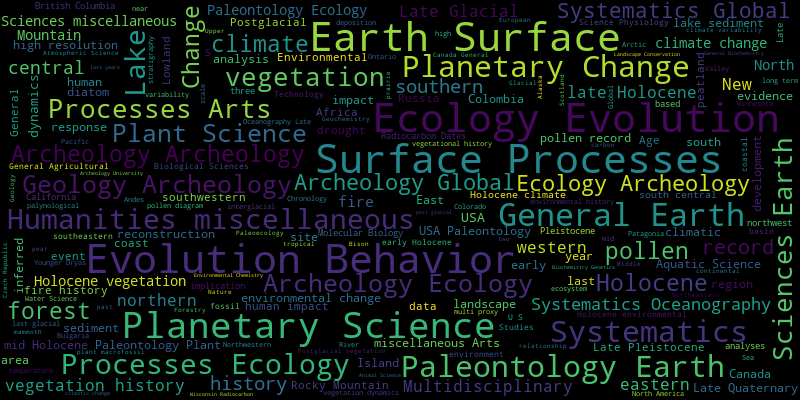

In [160]:
from wordcloud import WordCloud

pos_text = " ".join(train_df[train_df["target"] == 1]["text"].tolist())
neg_text = " ".join(train_df[train_df["target"] == 0]["text"].tolist())

wordcloud = WordCloud(max_font_size=40, width=800, height=400)
wordcloud.generate(pos_text).to_image()

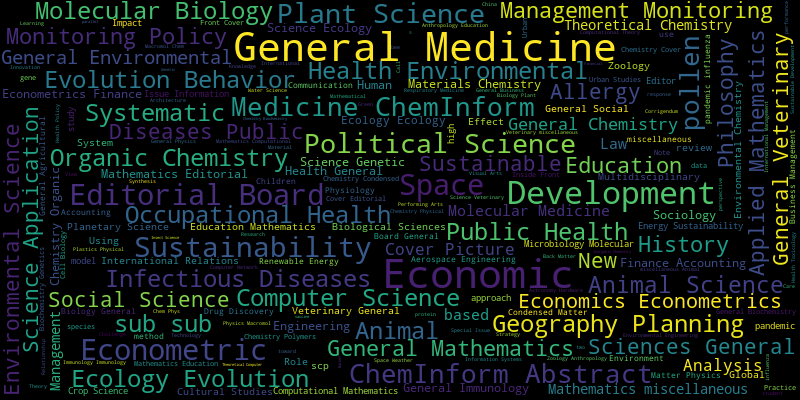

In [161]:
wordcloud.generate(neg_text).to_image()

#### Examine class distribution in train split

In [162]:
train_df["target"].value_counts(normalize=True)

0    0.748018
1    0.251982
Name: target, dtype: float64

## 5. Baseline Modelling

In [163]:
train_df.columns

Index(['container-title', 'is-referenced-by-count', 'target', 'published_year',
       'contains_author', 'text'],
      dtype='object')

##### Split X and y

In [164]:
feature = ['container-title', 'is-referenced-by-count', 'published_year', 'contains_author', 'text']
X_train, y_train = train_df[feature], train_df["target"]
X_test, y_test = test_df[feature], test_df["target"]

##### Define Pre-Processing Pipeline

In [166]:
from sklearn.compose import make_column_transformer  
from sklearn.preprocessing import OneHotEncoder, StandardScaler  

# Dividing the feature types
text_features = "text"
categorical_features = ["container-title"]
binary_feature = [ "contains_author"]
numeric_features = ["is-referenced-by-count", "published_year"]

# Transformers
binary_transformer = OneHotEncoder(drop='if_binary', dtype = int)
categorical_transformer = OneHotEncoder(handle_unknown="ignore", sparse=False, dtype = int)
numeric_transformer = StandardScaler()
text_transformer = CountVectorizer(stop_words="english", max_features= 100)

# Create the column transformer
preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (binary_transformer, binary_feature),
    (categorical_transformer, categorical_features),
    (text_transformer, text_features)
)

preprocessor

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['is-referenced-by-count', 'published_year']),
                                ('onehotencoder-1',
                                 OneHotEncoder(drop='if_binary',
                                               dtype=<class 'int'>),
                                 ['contains_author']),
                                ('onehotencoder-2',
                                 OneHotEncoder(dtype=<class 'int'>,
                                               handle_unknown='ignore',
                                               sparse=False),
                                 ['container-title']),
                                ('countvectorizer',
                                 CountVectorizer(max_features=100,
                                                 stop_words='english'),
                                 'text')])

##### Check Transformed Data

In [167]:
transformed_X_train = preprocessor.fit_transform(X_train)
col_names = (numeric_features + preprocessor.named_transformers_["onehotencoder-1"].get_feature_names_out().tolist() + preprocessor.named_transformers_["onehotencoder-2"].get_feature_names_out().tolist() + preprocessor.named_transformers_["countvectorizer"].get_feature_names_out().tolist())
transformed_X_train_df = pd.DataFrame(transformed_X_train, columns = col_names)
transformed_X_train_df.head()

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


is-referenced-by-count  published_year  contains_author_True  \
0               -0.397155        0.300146                   0.0   
1                0.037354        0.300146                   0.0   
2                0.167707       -0.608174                   0.0   
3                0.189433       -1.153166                   1.0   
4                0.906374        0.300146                   0.0   

   container-title_Accounting &amp; Finance  \
0                                       0.0   
1                                       0.0   
2                                       0.0   
3                                       0.0   
4                                       0.0   

   container-title_Acta Agriculturae Scandinavica, Section A — Animal Science  \
0                                                                         0.0   
1                                                                         0.0   
2                                                                         0.0   
3                                                                         0.0   
4                                                                         0.0   

   container-title_Acta Astronautica  \
0                                0.0   
1                                0.0   
2                                0.0   
3                                0.0   
4                                0.0   

   container-title_Acta Obstetricia et Gynecologica Scandinavica  \
0                                                            0.0   
1                                                            0.0   
2                                                            0.0   
3                                                            0.0   
4                                                            0.0   

   container-title_Acta Paediatrica  \
0                               0.0   
1                               0.0   
2                               0.0   
3                               0.0   
4                               0.0   

   container-title_Activities, Adaptation &amp; Aging  \
0                                                 0.0   
1                                                 0.0   
2                                                 0.0   
3                                                 0.0   
4                                                 0.0   

   container-title_Advanced Functional Materials  ...  surface  \
0                                            0.0  ...      0.0   
1                                            0.0  ...      0.0   
2                                            0.0  ...      0.0   
3                                            0.0  ...      0.0   
4                                            0.0  ...      0.0   

   sustainability  sustainable  systematics  technology  theoretical  \
0             0.0          0.0          0.0         0.0          0.0   
1             0.0          0.0          0.0         0.0          0.0   
2             0.0          0.0          0.0         0.0          0.0   
3             0.0          0.0          0.0         0.0          0.0   
4             1.0          0.0          0.0         0.0          0.0   

   vegetation  veterinary  water  zoology  
0         0.0         0.0    0.0      0.0  
1         0.0         0.0    0.0      0.0  
2         0.0         0.0    0.0      0.0  
3         0.0         0.0    0.0      0.0  
4         0.0         0.0    0.0      0.0  

[5 rows x 912 columns]

#### Logistic Regression

In [168]:
from sklearn.linear_model import LogisticRegression 

# The model pipeline

logreg_model = make_pipeline(preprocessor, LogisticRegression(max_iter=1000, random_state=123))

# The mean and std of the cross validated scores for all metrics as a dataframe

classification_metrics = ["accuracy", "precision", "recall", "f1"]

cross_val_results['logreg'] = pd.DataFrame(
    cross_validate(
        logreg_model,
        X_train,
        y_train,
        scoring=classification_metrics,
        return_train_score=True
    )
).agg(['mean', 'std']).round(3).T

cross_val_results['logreg']

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sp

mean    std
fit_time         0.117  0.012
score_time       0.023  0.004
test_accuracy    0.977  0.005
train_accuracy   0.987  0.001
test_precision   0.980  0.012
train_precision  0.997  0.001
test_recall      0.928  0.015
train_recall     0.952  0.004
test_f1          0.953  0.010
train_f1         0.974  0.002

#### LogReg - Preliminary investigation on feature importance for Logistic Regression

In [169]:
model_params = logreg_model.named_steps['logisticregression'].get_params()
model_params

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 123,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [170]:
logreg_model.fit(X_train, y_train)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['is-referenced-by-count',
                                                   'published_year']),
                                                 ('onehotencoder-1',
                                                  OneHotEncoder(drop='if_binary',
                                                                dtype=<class 'int'>),
                                                  ['contains_author']),
                                                 ('onehotencoder-2',
                                                  OneHotEncoder(dtype=<class 'int'>,
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  ['container-title']),
                                                 ('countvectorizer',
                                                  CountVectorizer(max_features=100,
                                                                  stop_words='english'),
                                                  'text')])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, random_state=123))])

In [171]:
data = {
    "coefficient": logreg_model.named_steps["logisticregression"].coef_.flatten().tolist(),
    "magnitude": np.absolute(
        logreg_model.named_steps["logisticregression"].coef_.flatten().tolist()
    ),
}
coef_df = pd.DataFrame(data, index=col_names).sort_values(
    "magnitude", ascending=False
)

# Top 30 features contributing for positive class
coef_df.query('coefficient > 0').head(30)

coefficient  \
contains_author_True                                                2.055487   
vegetation                                                          1.966205   
archeology                                                          1.919705   
lake                                                                1.768012   
multidisciplinary                                                   1.699452   
late                                                                1.547381   
holocene                                                            1.521195   
surface                                                             1.453334   
paleontology                                                        1.437643   
container-title_Plains Anthropologist                               1.319932   
container-title_New Phytologist                                     1.250826   
container-title_Doklady Biological Sciences                         1.238842   
climate                                                             1.224016   
central                                                             1.132256   
container-title_Hydrobiologia                                       1.110123   
container-title_Nature Communications                               1.051188   
environmental                                                       1.029899   
southern                                                            1.028357   
container-title_Grana                                               0.951240   
container-title_Annals of Botany                                    0.926210   
container-title_Forest Ecology and Management                       0.924841   
container-title_Proceedings of the National Academy of Sciences     0.917889   
container-title_Integrative Zoology                                 0.886599   
container-title_Communications Biology                              0.866946   
container-title_MethodsX                                            0.838959   
earth                                                               0.819111   
container-title_Nature Plants                                       0.800991   
sciences                                                            0.798434   
container-title_PNAS Nexus                                          0.787274   
container-title_Data in Brief                                       0.787233   

                                                                 magnitude  
contains_author_True                                              2.055487  
vegetation                                                        1.966205  
archeology                                                        1.919705  
lake                                                              1.768012  
multidisciplinary                                                 1.699452  
late                                                              1.547381  
holocene                                                          1.521195  
surface                                                           1.453334  
paleontology                                                      1.437643  
container-title_Plains Anthropologist                             1.319932  
container-title_New Phytologist                                   1.250826  
container-title_Doklady Biological Sciences                       1.238842  
climate                                                           1.224016  
central                                                           1.132256  
container-title_Hydrobiologia                                     1.110123  
container-title_Nature Communications                             1.051188  
environmental                                                     1.029899  
southern                                                          1.028357  
container-title_Grana                                             0.951240  
container-title_Annals of Botany            

In [172]:
# Top 30 features contributing for negative class
coef_df.query('coefficient < 0').head(30)

coefficient  \
space                                                            -1.613124   
economics                                                        -1.570959   
arts                                                             -1.503721   
container-title_Plants                                           -1.481859   
econometrics                                                     -1.463870   
published_year                                                   -1.378280   
animals                                                          -1.355330   
sustainability                                                   -1.334195   
container-title_Journal of Post Keynesian Economics              -1.265581   
social                                                           -1.156589   
energy                                                           -1.149623   
mathematics                                                      -1.131331   
editorial                                                        -0.947014   
computer                                                         -0.923409   
influenza                                                        -0.862538   
health                                                           -0.853578   
education                                                        -0.844333   
animal                                                           -0.838705   
political                                                        -0.832841   
2015                                                             -0.826950   
container-title_American Journal of Botany                       -0.823031   
container-title_The Art Bulletin                                 -0.817178   
development                                                      -0.788161   
container-title_Scientific Reports                               -0.738210   
container-title_Journal of Energy &amp; Natural Resources Law    -0.736881   
cover                                                            -0.728647   
infectious                                                       -0.728446   
information                                                      -0.696996   
sustainable                                                      -0.670632   
pandemic                                                         -0.653086   

                                                               magnitude  
space                                                           1.613124  
economics                                                       1.570959  
arts                                                            1.503721  
container-title_Plants                                          1.481859  
econometrics                                                    1.463870  
published_year                                                  1.378280  
animals                                                         1.355330  
sustainability                                                  1.334195  
container-title_Journal of Post Keynesian Economics             1.265581  
social                                                          1.156589  
energy                                                          1.149623  
mathematics                                                     1.131331  
editorial                                                       0.947014  
computer                                                        0.923409  
influenza                                                       0.862538  
health                                                          0.853578  
education                                                       0.844333  
animal                                                          0.838705  
political                                                       0.832841  
2015                                                            0.826950  
container-title_American Journal of Botany                      0.823

### Build and Compare Multiple Models

In [173]:
# Helper function for comparing models
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns pandas Series with mean and std of cross validation
    """
    scores = cross_validate(model, X_train, y_train, **kwargs)
    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []
    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))
    return pd.Series(data=out_col, index=mean_scores.index)


In [174]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from lightgbm.sklearn import LGBMClassifier

results_dict = {}
models = {
	"dummy": DummyClassifier(random_state = 123),
    "decision tree": DecisionTreeClassifier(random_state=123, max_depth=200),
    "kNN": KNeighborsClassifier(),
    "RBF SVM": SVC(random_state=123),
    'RF': RandomForestClassifier(class_weight="balanced", random_state=123),
    'LGBM': LGBMClassifier(random_state=123)
}

for key, model in models.items():
    pipe = make_pipeline(preprocessor, model)
    results_dict[key] = mean_std_cross_val_scores(pipe, X_train, y_train, cv=5, return_train_score=True, scoring=classification_metrics)

results_df = pd.DataFrame(results_dict).T
results_df



/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/sklearn/preproce

fit_time         score_time      test_accuracy  \
dummy          0.044 (+/- 0.003)  0.016 (+/- 0.002)  0.748 (+/- 0.001)   
decision tree  0.130 (+/- 0.011)  0.017 (+/- 0.001)  0.970 (+/- 0.009)   
kNN            0.056 (+/- 0.006)  0.061 (+/- 0.028)  0.967 (+/- 0.007)   
RBF SVM        0.330 (+/- 0.036)  0.084 (+/- 0.009)  0.981 (+/- 0.005)   
RF             0.374 (+/- 0.009)  0.031 (+/- 0.002)  0.982 (+/- 0.005)   
LGBM           0.130 (+/- 0.030)  0.023 (+/- 0.002)  0.982 (+/- 0.005)   

                  train_accuracy     test_precision    train_precision  \
dummy          0.748 (+/- 0.000)  0.000 (+/- 0.000)  0.000 (+/- 0.000)   
decision tree  1.000 (+/- 0.000)  0.955 (+/- 0.027)  1.000 (+/- 0.000)   
kNN            0.977 (+/- 0.002)  0.977 (+/- 0.012)  0.984 (+/- 0.004)   
RBF SVM        0.990 (+/- 0.001)  0.993 (+/- 0.008)  0.998 (+/- 0.001)   
RF             0.999 (+/- 0.001)  0.987 (+/- 0.010)  0.998 (+/- 0.002)   
LGBM           0.999 (+/- 0.000)  0.980 (+/- 0.007)  0.999 (+/- 0.001)   

                     test_recall       train_recall            test_f1  \
dummy          0.000 (+/- 0.000)  0.000 (+/- 0.000)  0.000 (+/- 0.000)   
decision tree  0.923 (+/- 0.010)  0.998 (+/- 0.002)  0.939 (+/- 0.017)   
kNN            0.892 (+/- 0.028)  0.924 (+/- 0.007)  0.932 (+/- 0.016)   
RBF SVM        0.934 (+/- 0.013)  0.960 (+/- 0.004)  0.962 (+/- 0.009)   
RF             0.942 (+/- 0.020)  1.000 (+/- 0.001)  0.964 (+/- 0.010)   
LGBM           0.949 (+/- 0.023)  0.996 (+/- 0.002)  0.964 (+/- 0.011)   

                        train_f1  
dummy          0.000 (+/- 0.000)  
decision tree  0.999 (+/- 0.001)  
kNN            0.953 (+/- 0.005)  
RBF SVM        0.979 (+/- 0.002)  
RF             0.999 (+/- 0.001)  
LGBM           0.998 (+/- 0.001)

#### LogReg - Hyperparameter Tuning for Logistic Regression

In [ ]:
# from scipy.stats import loguniform, randint

# # fit the model
# logreg_model.fit(X_train, y_train)

# # get the length of the vocabulary
# vocab_len = len(  
#     logreg_model.named_steps["columntransformer"]
#     .named_transformers_["countvectorizer"]
#     .get_feature_names_out()
# )
# # create a distribution of the parameters
# param_dist = {  
#     # "columntransformer__countvectorizer__max_features": np.arange(5000, vocab_len, 200),
#     "logisticregression__C": loguniform(1e-3, 1e3),
#     "logisticregression__class_weight": ["balanced", None],
# }

# # Perform a randomized search 
# random_search = RandomizedSearchCV(  
#     logreg_model,
#     param_distributions=param_dist,
#     n_iter=10,
#     verbose=1,
#     n_jobs=-1,
#     scoring='recall',
#     random_state=123,
# )
# random_search.fit(X_train, y_train)